In [1]:
import sys
sys.path.append('../..')

In [2]:
import cv2

import os
import psutil

import random
import math
import copy
from functools import partial
from collections import Counter

import torch 
from torch import optim
from torch.optim import lr_scheduler
from torch import nn
from torch.nn import functional as F

import multiprocessing.dummy as mp

from pytorch_lightning import Trainer
from pytorch_lightning.core import LightningModule
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers.tensorboard import TensorBoardLogger


from lib.schedulers import DelayedScheduler
from lib.datasets import (max_lbl_nums, actual_lbl_nums, 
                          patches_rgb_mean_av1, patches_rgb_std_av1, 
                          get_train_test_img_ids_split)
from lib.dataloaders import PatchesDataset, WSIPatchesDatasetRaw, WSIPatchesDummyDataloader
from lib.augmentations import augment_v1_clr_only, augment_empty_clr_only
from lib.losses import SmoothLoss
from lib.trainers import WSIModuleV1

from lib.models.unetv1 import get_model
from lib.models.features_map import FeaturesMap, TiledFeaturesMap
from lib.models.wsi_resnets import Resnet_64x8x8

from sklearn.metrics import cohen_kappa_score

from tqdm.auto import tqdm

import matplotlib.pyplot as plt

In [3]:
# import cv2
import numpy as np
# import pandas as pd
# from lib.datasets import patches_csv_path, patches_path
from lib.datasets import (patches_clean90_csv_path as patches_csv_path, patches_path,
                          patches_clean90_pkl_path as patches_pkl_path)
# from lib.dataloaders import imread, get_g_score_num, get_provider_num

In [4]:
train_img_ids, test_img_ids = get_train_test_img_ids_split()

test_img_ids[:4]

['e8baa3bb9dcfb9cef5ca599d62bb8046',
 '9b2948ff81b64677a1a152a1532c1a50',
 '5b003d43ec0ce5979062442486f84cf7',
 '375b2c9501320b35ceb638a3274812aa']

In [5]:
from lib.dataloaders import WSIPatchesDataloader, WSIPatchesDatasetRaw
from lib.utils import get_pretrained_model, get_features

In [6]:
batch_size = 16

In [7]:
#train_batch_path = '/mnt/HDDData/pdata/processed/pretrained_64x8x8/train/{}/'
#test_batch_path = '/mnt/HDDData/pdata/processed/pretrained_64x8x8/val/'

train_batch_path = '/mnt/SSDData/pdata/processed/pretrained_64x8x8/train/{}/'
test_batch_path = '/mnt/SSDData/pdata/processed/pretrained_64x8x8/val/'

train_loader = WSIPatchesDummyDataloader(train_batch_path, precalc_epochs=6, batch_size=batch_size, shuffle=True)
val_loader = WSIPatchesDummyDataloader(test_batch_path, precalc_epochs=6, batch_size=batch_size, shuffle=False)

In [8]:
batch = next(iter(train_loader))

In [9]:
features, ys, xs, provider, isup_grade, gleason_score = batch

In [10]:
b = 0

In [101]:
def T(m):
    return list(map(list, zip(*m)))

def flip_h(m):
    return [r[::-1] for r in m]

def flip_v(m):
    return m[::-1]

def d8_transform(m, d8):
    if d8 & 0b001:
        m = T(m)
    if d8 & 0b010:
        m = flip_h(m)        
    if d8 & 0b100:
        m = flip_v(m)  
        
    return m

def get_fg_score(coords, p=2):        
    ns = [c[2] for r in coords for c in r if c is not None]
    return sum([c**p for c in Counter(ns).values()])

def get_bg_score(coords, p=2):
    tmp = np.array(coords) == None
    dist = cv2.distanceTransform(tmp.astype(np.uint8), cv2.DIST_L1, 5) ** p
    return dist.sum()

def get_blob(s_idx, s_coords, t_y, t_x, t_coords, n, d8):
    def p_coords(c_idx, s_coords, t_start_c, t_coords):
            y, x = s_coords[c_idx]

            # Координаты относительно таргета                
            t_y, t_x = y+t_start_c[0], x+t_start_c[1]
            # Если target не занят
            if (t_y >= 0 and t_y < len(t_coords) and 
                t_x >= 0 and t_x < len(t_coords[t_y]) and 
                t_coords[t_y][t_x] is None):
                t_coords[t_y][t_x] = (y, x, n, d8)

                del s_coords[c_idx]

                # Перебор соседских клеток по периметру
                for dy in range(-1, 2, 1):
                    for dx in range(-1, 2, 1):
                        try:
                            c_ = y+dy, x+dx
                            c_idx_ = s_coords.index(c_)  # foreground с такими координатами существует
                            n_s, n_t = p_coords(c_idx_, s_coords, t_start_c, t_coords)
                        except:
                            pass
    
    y, x = s_coords[s_idx]
    t_start_c = (-y+t_y, -x+t_x)
    
    p_coords(s_idx, s_coords, t_start_c, t_coords)

def mean_children_score(coords, t_coords, n, c_num, p):
    scores = []
    for _ in range(c_num):
        while len(coords) > 0:
            # d8 = 0
            d8 = random.randint(0, 7)

            s_idx = random.randint(0, len(coords)-1)

            t_coords = d8_transform(t_coords, d8)

            empty_t_coords = [(n_r, n_c) for n_r, r in enumerate(t_coords) 
                              for n_c, c in enumerate(r) if c is None]
            t_y, t_x = random.choice(empty_t_coords)

            n += 1
            get_blob(s_idx, coords, t_y, t_x, t_coords, n, d8) 

        scores.append(get_fg_score(t_coords, p))

    return sum(scores) / len(scores)

In [13]:
from scipy import ndimage

In [15]:
#for y in range(20):
#    for x in range(20):
#        if tmp[y, x] is None:
#            tmp[y, x] = (-1, -1, -1, -1)
#        t_coords[:, y, x] = tmp[y, x]

In [108]:
def d8_transform(m, d8):
    if d8 & 0b001:
        m = m.transpose(1, 0, 2)
    if d8 & 0b010:
        m = m[:, ::-1]        
    if d8 & 0b100:
        m = m[::-1, :]  
        
    return m

def get_fg_score(img, p=2):        
    return (np.unique(img[..., 2], return_counts=True)[1][1:]**p).sum()

def get_bg_score(img, p=2):
    tmp = (img[..., 0] == -1).astype(np.uint8)
    dist_sum = (cv2.distanceTransform(tmp, cv2.DIST_L1, 5)**p).sum()
    return dist_sum

In [109]:
#b = -1

In [110]:
#b += 1

r_mask = ys[b] > - 1

y_min, x_min = ys[b, r_mask].min(), xs[b, r_mask].min()
y_max, x_max = ys[b, r_mask].max(), xs[b, r_mask].max()

s_h = y_max - y_min + 1
s_w = x_max - x_min + 1

t_h, t_w = 20, 20

m_pad = t_w

In [111]:
p = 1.4
p0, p1 = 1.4, 1

In [112]:
n_ys = (ys[b, r_mask]-y_min)
n_xs = (xs[b, r_mask]-x_min)

In [133]:
t_img = np.full((t_h, t_w, 4), -1, dtype=np.int16)

s_img = np.zeros((s_h, s_w), dtype=np.uint8)
s_img[n_ys, n_xs] = 1

In [134]:
%%time

n = 0
a = 200
mask = np.ones((s_h+2*m_pad, s_w+2*m_pad), dtype=np.uint8)

while s_img.max() != 0:
    c_s_img = s_img[None, ...].repeat(a, 0)
    c_t_img = t_img[None, ...].repeat(a, 0) 
    
    d8 = np.random.randint(8, size=(a,))
    # c_t_img = d8_transform(c_t_img, d8)
    
    t_empty_mask = t_img[..., 0] == -1
    
    t_empty_ys, t_empty_xs = np.where(t_empty_mask)
    r = np.random.randint(len(t_empty_ys), size=(a,))
    t_y, t_x = t_empty_ys[r], t_empty_xs[r]   
    
    s_fg_ys, s_fg_xs = np.where(s_img != 0)
    r = np.random.randint(len(s_fg_ys), size=(a,))
    s_y, s_x = s_fg_ys[r], s_fg_xs[r]
    
    m_y = s_y+m_pad-t_y
    m_x = s_x+m_pad-t_x
    
    scores = []
    for i in range(a):
        mask.fill(1)
        mask[m_y[i]:m_y[i]+t_h, m_x[i]:m_x[i]+t_w] = ~t_empty_mask
        
        fimg = cv2.floodFill(c_s_img[i], mask[m_pad-1:-m_pad+1, m_pad-1:-m_pad+1], 
                             (s_x[i], s_y[i]), 2, flags=8) 
        
        if fimg[0] > 0:
            blob_yxs = np.where(fimg[1] == 2)
            c_t_img[i, blob_yxs[0]-s_y[i]+t_y[i], blob_yxs[1]-s_x[i]+t_x[i]] =\
                np.stack(blob_yxs + (np.full_like(blob_yxs[0], n+1), 
                                     np.full_like(blob_yxs[0], d8[i])), axis=-1)

            c_s_img[c_s_img == 2] = 0
        else:
            print("WTF?")

        scores.append(get_fg_score(c_t_img[i], p0) + 0.5 * get_bg_score(c_t_img[i], p1)**0.5)
        
    scores = np.array(scores)
    
    best_i = scores.argmax()

    s_img, t_img = c_s_img[best_i], c_t_img[best_i]
    n += 1

CPU times: user 236 ms, sys: 0 ns, total: 236 ms
Wall time: 235 ms


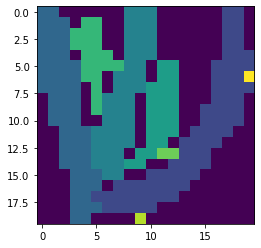

In [135]:
plt.imshow(t_img[..., 2]);

In [124]:
t_img = np.full((t_h, t_w, 4), -1, dtype=np.int16)

s_img = np.zeros((s_h, s_w), dtype=np.uint8)
s_img[n_ys, n_xs] = 1

In [125]:
%%time

sequence = []
n = 0
mask = np.ones((s_h+2*m_pad, s_w+2*m_pad), dtype=np.uint8)

while s_img.max() != 0:
    best_step = None
    best_score = -99999999  
    
    for a in range(200):
        c_s_img = s_img.copy()
        c_t_img = t_img.copy()

        d8 = random.randint(0, 7)
        c_t_img = d8_transform(c_t_img, d8)
        
        t_empty_mask = c_t_img[..., 0] == -1

        t_empty_ys, t_empty_xs = np.where(t_empty_mask)
        r = random.randint(0, len(t_empty_ys)-1)
        t_y, t_x = t_empty_ys[r], t_empty_xs[r]

        s_fg_ys, s_fg_xs = np.where(c_s_img != 0)
        r = random.randint(0, len(s_fg_ys)-1)
        s_y, s_x = s_fg_ys[r], s_fg_xs[r]

        mask.fill(1)

        m_y = s_y+m_pad-t_y
        m_x = s_x+m_pad-t_x

        mask[m_y:m_y+t_h, m_x:m_x+t_w] = ~t_empty_mask

        fimg = cv2.floodFill(c_s_img, mask[m_pad-1:-m_pad+1, m_pad-1:-m_pad+1], 
                             (s_x, s_y), 2, flags=8)

        if fimg[0] > 0:
            blob_yxs = np.where(fimg[1] == 2)
            c_t_img[blob_yxs[0]-s_y+t_y, blob_yxs[1]-s_x+t_x] =\
                    np.stack(blob_yxs + (np.full_like(blob_yxs[0], n+1), 
                                         np.full_like(blob_yxs[0], d8)), axis=-1)

            c_s_img[c_s_img == 2] = 0
        else:
            print("WTF?")

        score = get_fg_score(c_t_img, p0) + 0.5 * get_bg_score(c_t_img, p1)**0.5
        
        if score > best_score:
            best_state = c_s_img, c_t_img
            best_score = score
            
    s_img, t_img = best_state
    n += 1

    #if c_s_img.max() == 0:
    #    break

CPU times: user 227 ms, sys: 0 ns, total: 227 ms
Wall time: 226 ms


In [95]:
get_fg_score(c_t_img, p)

1834028.564998508

In [264]:
#b = -1

In [265]:
#b += 1

r_mask = ys[b] > - 1

y_min, x_min = ys[b, r_mask].min(), xs[b, r_mask].min()
y_max, x_max = ys[b, r_mask].max(), xs[b, r_mask].max()

s_h = y_max - y_min + 1
s_w = x_max - x_min + 1

t_h, t_w = 20, 20

In [96]:
n_ys = (ys[b, r_mask]-y_min).tolist()
n_xs = (xs[b, r_mask]-x_min).tolist()

In [97]:
p = 1.4

In [98]:
p0, p1 = 1.4, 1

In [106]:
t_coords = [[None for _ in range(t_w)] for _ in range(t_h)] 
coords = list(zip(n_ys, n_xs))

sequence = []

n = 0

In [107]:
%%time

while len(coords) > 0:
    best_step = None
    best_score = -99999999

    for a in range(200):
        c_coords = copy.deepcopy(coords)
        c_t_coords = copy.deepcopy(t_coords)        
        
        # d8 = 0
        d8 = random.randint(0, 7)

        s_idx = random.randint(0, len(coords)-1)
        if a % 4 == 0 and best_step is not None:
            s_idx, *_ = best_step

        c_t_coords = d8_transform(c_t_coords, d8)

        empty_t_coords = [(n_r, n_c) for n_r, r in enumerate(t_coords) 
                          for n_c, c in enumerate(r) if c is None]
        t_y, t_x = random.choice(empty_t_coords)
        
        get_blob(s_idx, c_coords, t_y, t_x, c_t_coords, n+1, d8)
        
        # score = mean_children_score(c_coords, c_t_coords, n+1, 40, p0)
        score = get_fg_score(c_t_coords, p0) + 0.1*get_bg_score(c_t_coords)**0.5

        if score > best_score:
            best_step = s_idx, d8, t_y, t_x
            best_score = score
            
    sequence.append(best_step)
    s_idx, d8, t_y, t_x = best_step
    n += 1
    t_coords = d8_transform(t_coords, d8)
    get_blob(s_idx, coords, t_y, t_x, t_coords, n, d8)
    
    # break

CPU times: user 1.72 s, sys: 0 ns, total: 1.72 s
Wall time: 1.72 s


In [1014]:
get_fg_score(t_coords, p)

763.8988076286804

In [905]:
t_coords = [[None for _ in range(t_w)] for _ in range(t_h)] 
coords = list(zip(n_ys, n_xs))

for n, (s_idx, d8, t_y, t_x) in enumerate(sequence):
    t_coords = d8_transform(t_coords, d8)
    get_blob(s_idx, coords, t_y, t_x, t_coords, n+1, d8) 

In [906]:
get_fg_score(t_coords, p)

925.8393856066778

In [907]:
s_img = np.zeros((s_h, s_w)) - 1
t_img = np.zeros((t_h, t_w)) - 1

s_img[ys[b, r_mask]-y_min, xs[b, r_mask]-x_min] = 0

for n_r, r in enumerate(t_coords):
    for n_c, tmp in enumerate(r):
        if tmp is not None:
            y, x, n, d8 = tmp
            t_img[n_r, n_c] = n
            s_img[y, x] = n

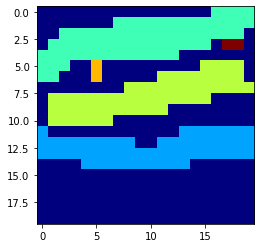

In [908]:
plt.imshow(t_img, cmap='jet');

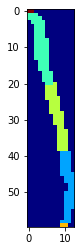

In [909]:
plt.imshow(s_img, cmap='jet');

In [896]:
(s_img > -1).sum()

183

In [897]:
np.unique(s_img)

array([-1.,  0.,  1.,  3.,  4.,  5.])

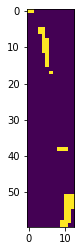

In [898]:
plt.imshow(s_img == 0);

In [ ]:
#genome = []
#for _ in range(1000):
#    genome.append(((random.randint(0, s_h-1), random.randint(0, s_w-1)), 
#                   (random.randint(0, t_h-1), random.randint(0, t_w-1)),
#                   random.randint(0, 7)))

n = 0
for ((s_y, s_x), (t_y, t_x), d8) in genome:
    if t_coords[t_y][t_x] is not None:
        continue   
        
    if (s_y, s_x) not in coords:
        continue     
        
    t_coords = d8_transform(t_coords, d8)    
    s_idx = coords.index((s_y, s_x))
    n += 1
    get_blob(s_idx, coords, t_y, t_x, t_coords, n, d8)